# Chunking Fiqa Dataset
In this Notebook I will analyse the Fiqa Dataset and transform it to apply some chunking strategies

## Chunking Considerations
- **What kind of Data are we working with?**
    - size of content (long document like articles or book, or shorter content like tweets or messages)
    - structure of content (plain text, code, tables,...)
- **Which embedding model are we using and what chunk size does it perform optimally on?**
- **How will the user queries look like?**
    - Short and specific or long and complex
- **How will the retrieved results be use?**
    - e.g. sematic search, question answering, summarization

### Papers
- [Pinecone: Chunking Strategies](https://www.pinecone.io/learn/chunking-strategies/)
- [Paper about Financial Report Chunking for RAG](https://arxiv.org/html/2402.05131v2)


## Analysis
The Fiqa Dataset is a long text dataset. It is already divided into rows.

In [5]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of Rows (Chunks): 57638
Length of Rows:  [16990, 13604, 13080, 10643, 10506, 10276, 10082, 10054, 9683, 9503, 9437, 9363, 9317, 9185, 9140, 9093, 9085, 9023, 8946, 8937, 8663, 8633, 8608, 8377, 8348, 8294, 8193, 8132, 8068, 7992, 7954, 7850, 7624, 7607, 7552, 7550, 7515, 7511, 7510, 7498, 7478, 7407, 7356, 7342, 7334, 7333, 7289, 7261, 7260, 7250, 7242, 7222, 7213, 7171, 7166, 7116, 7011, 6992, 6987, 6982, 6941, 6941, 6936, 6915, 6878, 6856, 6834, 6773, 6743, 6714, 6691, 6665, 6649, 6642, 6639, 6626, 6620, 6619, 6583, 6530, 6522, 6513, 6512, 6498, 6480, 6438, 6437, 6419, 6412, 6406, 6397, 6385, 6365, 6353, 6300, 6265, 6257, 6200, 6191, 6146, 6146, 6061, 6035, 6032, 6030, 6004, 5992, 5987, 5947, 5927, 5925, 5924, 5923, 5901, 5887, 5875, 5871, 5844, 5809, 5789, 5781, 5770, 5765, 5765, 5757, 5729, 5711, 5706, 5702, 5701, 5695, 5691, 5689, 5676, 5661, 5660, 5644, 5644, 5640, 5635, 5634, 5626, 5622, 5613, 5604, 5588, 5584, 5571, 5566, 5546, 5527, 5522, 5512, 5509, 5502, 5457, 5451, 5

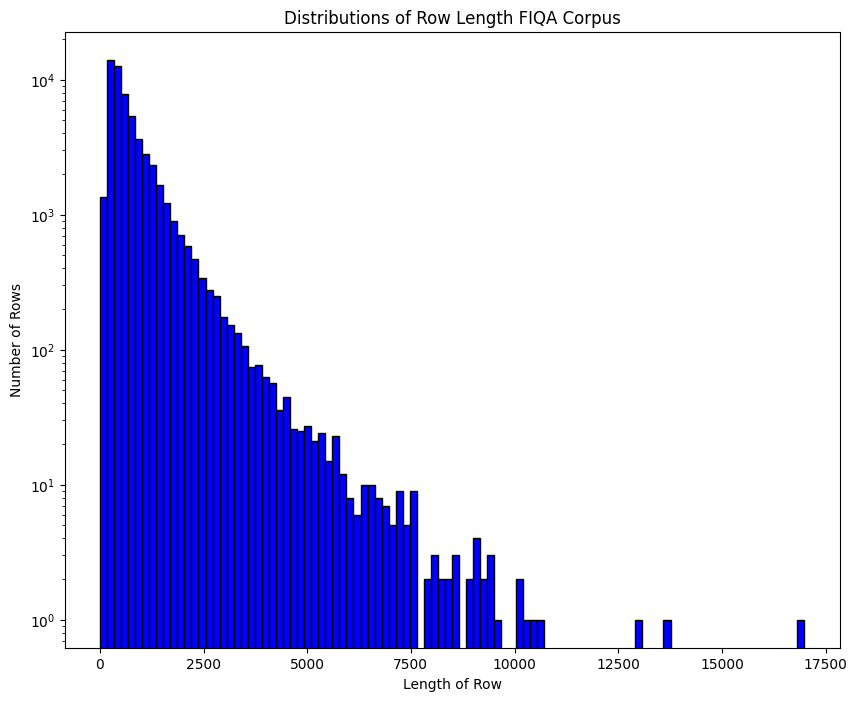

In [18]:
fiqa_corpus = load_dataset("explodinggradients/fiqa", "corpus")

print('Number of Rows (Chunks):' , len(fiqa_corpus['corpus']['doc']))

length_of_rows = []
for doc in fiqa_corpus['corpus']['doc']:
    length_of_rows.append(len(doc))

length_of_rows.sort(reverse=True)
# len function counts number of characters
print('Length of Rows: ', length_of_rows)

mean_length_of_rows = sum(length_of_rows)/len(length_of_rows)
print('Mean length of rows: ', round(mean_length_of_rows))


plt.figure(figsize=(10, 8))  
plt.hist(length_of_rows, bins=100, color='blue', edgecolor='black')  
plt.yscale('log')

plt.title('Distributions of Row Length FIQA Corpus')
plt.xlabel('Length of Row')
plt.ylabel('Number of Rows')

plt.show()

We can see that the size of the rows vary a lot and some are very long. So we need to get the full text and rechunk the data so we have a clean chunking strategy.

*Maybe analyze also the content of some chunks or just view the [dataset](https://huggingface.co/datasets/explodinggradients/fiqa).*

**Embed chunks and store into ChromaDB Vectorstore**

In [13]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.docstore.document import Document

vectorstore = Chroma(persist_directory='../vectorstores/original_chunks', embedding_function=OpenAIEmbeddings(model='text-embedding-3-small'))
corpus_len = len(fiqa_corpus['corpus'])

for index, doc in enumerate(fiqa_corpus["corpus"]):
    doc = Document(page_content=doc["doc"], metadata={"source": "local", "id": index})
    vectorstore.add_documents([doc])


- Duration for embeddings: 282 min
- Costs for embeddings: 0,20 $

### Evaluation of rag with original chunksize

In [1]:
import sys
import os

os.chdir('../')

from rag import Rag
from evaluator import RagEvaluator

/home/dabr/code/langchain-rag-eval/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
original_rag = Rag(chunkingstrategy='original_chunks', llm='gpt-3.5-turbo-0125', embedding='text-embedding-3-small')
original_eval = RagEvaluator(rag=original_rag, eval_llm='gpt-3.5-turbo-0125', embedding_function='text-embedding-3-small')

AttributeError: 'AnswerRelevancy' object has no attribute '__name__'

- time for evaluation = 5:23 min


In [3]:
result = fixed_1000_eval.get_mean_result()
print(result)

{'answer_relevancy': 0.5473, 'answer_correctness': 0.3108, 'context_recall': 0.4851, 'context_relevancy': 0.0965}


### Evaluation Result of RAG with orginal chunksizes. LLM as Judge = gpt-3.5-turbo.
- {'answer_relevancy': 0.4872, 'answer_correctness': 0.2545, 'context_recall': 0.3084, 'context_relevancy': 0.0}

In [16]:
original_gpt4_eval = RagEvaluator(rag=original_rag, eval_llm='gpt-4o', embedding_function='text-embedding-3-small')
result_2 = original_gpt4_eval.get_mean_result()
print(result_2)

passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 18
})


Evaluating: 100%|██████████| 72/72 [02:07<00:00,  1.78s/it]
passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 18
})


Evaluating: 100%|██████████| 72/72 [01:51<00:00,  1.55s/it]
passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 18
})


Evaluating: 100%|██████████| 72/72 [01:27<00:00,  1.21s/it]
passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 18
})


Evaluating: 100%|██████████| 72/72 [02:40<00:00,  2.22s/it]
passing column names as 'ground_truths' is deprecated and will be removed in the next version, please use 'ground_truth' instead. Note that `ground_truth` should be of type string and not Sequence[string] like `ground_truths`


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truths'],
    num_rows: 18
})


Evaluating: 100%|██████████| 72/72 [01:37<00:00,  1.36s/it]


{'answer_relevancy': 0.4394, 'answer_correctness': 0.197, 'context_recall': 0.0915, 'context_relevancy': 0.0}


### Evaluation Result of RAG with orginal chunksizes. LLM as Judge = gpt-4o.
- {'answer_relevancy': 0.4394, 'answer_correctness': 0.197, 'context_recall': 0.0915, 'context_relevancy': 0.0}